In [1]:
from dotenv import load_dotenv
from helpers.graphql_provider import SafesProvider
from helpers.hoprd_api import HoprdAPI
from helpers.utils import Utils
import matplotlib.pyplot as plt
import numpy as np

from models.economic_model import EconomicModel, Equations, Parameters, BudgetParameters, Equation
from models.peer import Peer
from models.subgraph_entry import SubgraphEntry
from models.tolopogy_entry import TopologyEntry

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

_ = load_dotenv()

### Instanciate an API handler

In [2]:
api = HoprdAPI(*Utils.apiHostAndKey('API_HOST', "API_KEY"))
safes_balances_subgraph_url = Utils.envvar('SAFES_BALANCES_SUBGRAPH_URL', str)
min_version = "2.0.7"


In [3]:
async def get_subgraph_data():
    key = "registeredNodesInNetworkRegistry"
    query_id = "SUBGRAPH_SAFES_BALANCES_QUERY_ID"
    safes_provider = SafesProvider(Utils.buildSubgraphURL(query_id))

    results = list[SubgraphEntry]()
    for safe in await safes_provider.get():
        results.extend([SubgraphEntry.fromDict(node) for node in safe[key]])

    return results

async def get_topology_data(api: HoprdAPI):
    channels = await api.all_channels(False)

    results = await Utils.aggregatePeerBalanceInChannels(channels.all)
    return [TopologyEntry.fromDict(*arg) for arg in results.items()]

async def get_peers(api: HoprdAPI):
    fields = ["peer_id", "peer_address", "reported_version"]

    node_result = await api.peers(params=fields, quality=0.5)

    return { Peer(*[item[f] for f in fields]) for item in node_result }

In [4]:
safes = await get_subgraph_data()
print(f"Subgraph size: {len(safes)}")

topology = await get_topology_data(api)
print(f"Topology size: {len(topology)}")

peers = await get_peers(api)
print(f"Number of peers: {len(peers)}")

Subgraph size: 654
Topology size: 437
Number of peers: 353


### Filter eligible peers

In [5]:
eligibles = Utils.mergeTopoPeersSafes(topology, peers, safes)

addresses_to_exclude = [peer.address for peer in eligibles if peer.version_is_old(min_version)]
Utils.exclude(eligibles, addresses_to_exclude)

addresses_to_exclude = [peer.address for peer in eligibles if peer.safe_allowance < 0]
Utils.exclude(eligibles, addresses_to_exclude)

Utils.allowManyNodePerSafe(eligibles)
print(f"Eligible peers: {len(eligibles)}")

Eligible peers: 261


### Define and apply economic model

In [6]:
equations = Equations(
    Equation("a * x", "l <= x <= c"), 
    Equation("a * c + (x - c) ** (1 / b)", "x > c")
)
parameters = Parameters(1, 1.4, 75000, 10000)
budget_params = BudgetParameters(150000, 2628000, 1, 365, 0.03, 1.0)
economic_model = EconomicModel(equations, parameters, budget_params)

In [7]:
for peer in eligibles:
    peer.economic_model = economic_model
Utils.rewardProbability(eligibles)

### Stake distribution

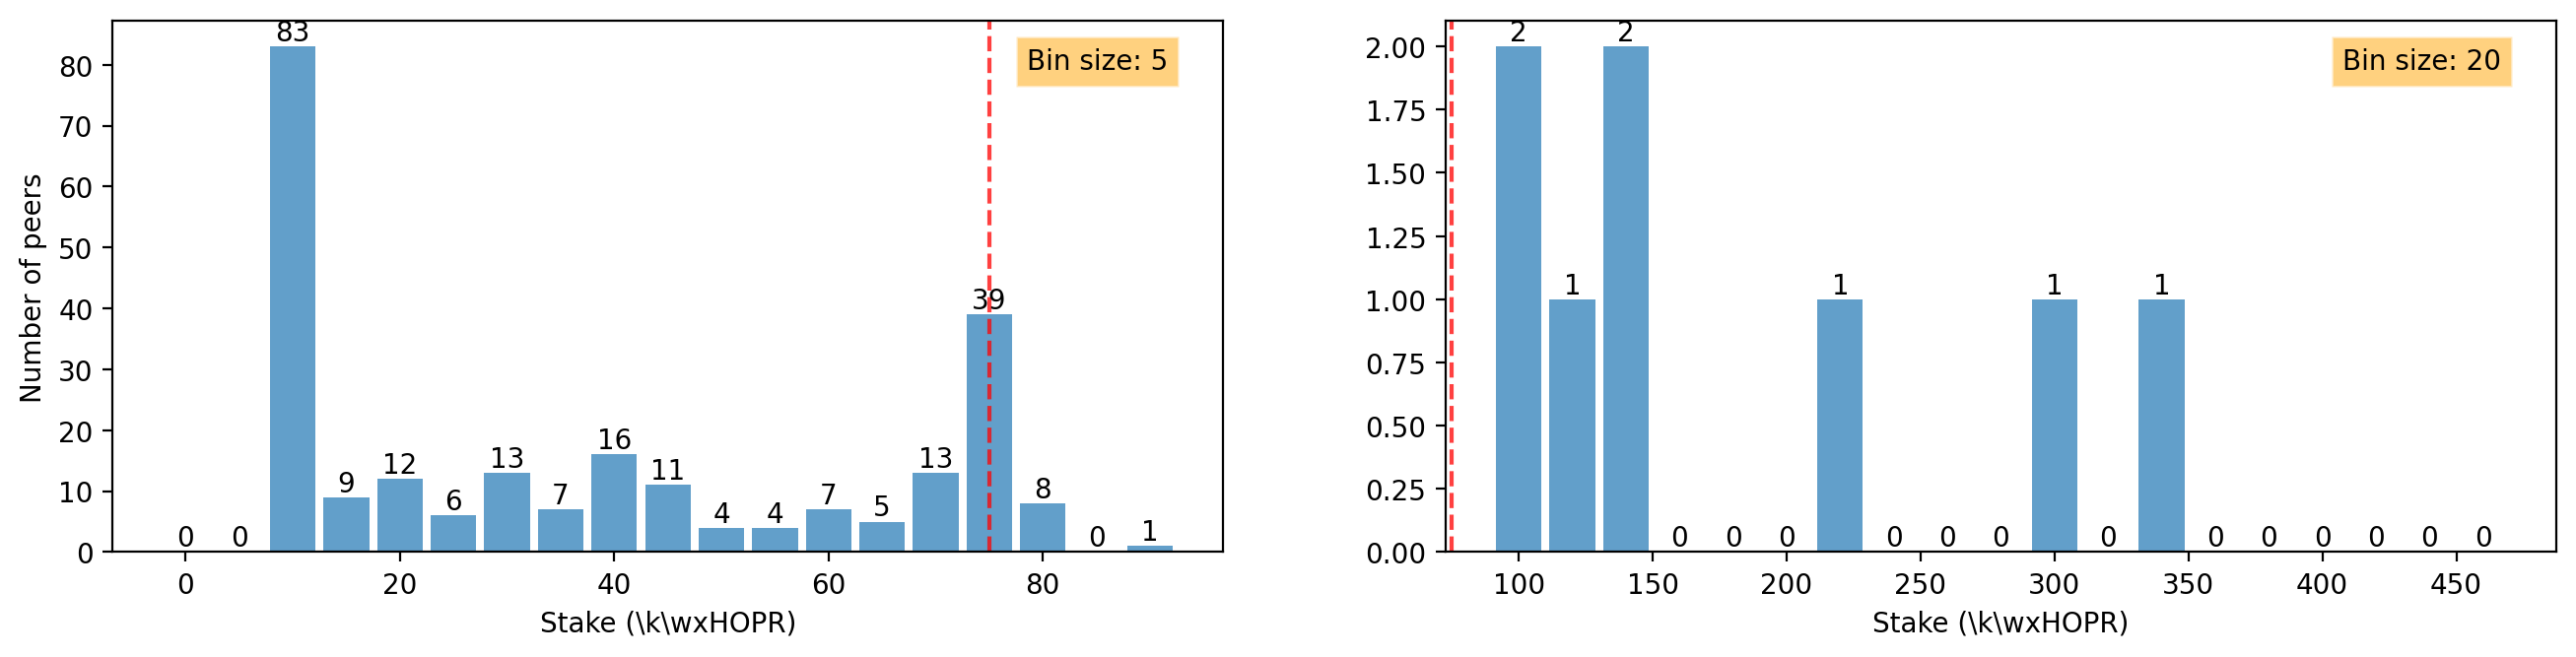

In [8]:
stakes = [peer.total_balance for peer in eligibles]

limits = [75000]
separators = [0, 100e3, 500e3]
splits = []
bins = []
for low, high in zip(separators, separators[1:]):
    splits.append([s for s in stakes if low < s < high])
    bins.append(list(range(int(low/1000), int(high/1000), int((high-low)/20/1000))))

_, axes = plt.subplots(1, len(splits), figsize=(8*len(splits), 3.5), sharex=False, sharey=False)

axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for ax, split, bin in zip(axes, splits, bins):
    _, edges, counts = ax.hist(list(map(lambda s: s/1000, split)), bins=bin, alpha=0.7, rwidth=0.85, align="left")
    [ax.axvline(lim/1000, color='r', linestyle='dashed', alpha=0.75) for lim in limits]
    ax.bar_label(counts)
    ax.set_xlabel("Stake (\k\wxHOPR)")
    t = ax.text(0.95, 0.95, f"Bin size: {edges[1]-edges[0]:.0f}", transform=ax.transAxes, ha='right', va='top')
    t.set_bbox(dict(facecolor='orange', alpha=0.5, edgecolor='white'))

_ = axes[0].set_ylabel("Number of peers")